# ## 1. 环境配置与数据准备

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(data_dir, test_ratio=0.2):
    valid_exts = ('.jpg', '.jpeg', '.JPG', '.JPEG')
    classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls)) and cls != "BACKGROUND_Google"]

    # 清空旧目录
    if os.path.exists("data/train"):
        shutil.rmtree("data/train")
    if os.path.exists("data/test"):
        shutil.rmtree("data/test")

    os.makedirs("data/train", exist_ok=True)
    os.makedirs("data/test", exist_ok=True)

    print(f"共发现类别数: {len(classes)}")

    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(valid_exts)]
        print(f"类 {cls} 含有图像数量: {len(images)}")
        
        train_imgs, test_imgs = train_test_split(images, test_size=test_ratio, random_state=42)

        os.makedirs(f"data/train/{cls}", exist_ok=True)
        os.makedirs(f"data/test/{cls}", exist_ok=True)
        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), f"data/train/{cls}/{img}")
        for img in test_imgs:
            shutil.copy(os.path.join(cls_path, img), f"data/test/{cls}/{img}")

if __name__ == "__main__":
    split_dataset("D:/dxtprojects/caltech-101/101_ObjectCategories")


配置文件

In [2]:
# %%
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import os
import numpy as np
from tqdm import tqdm

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)


# ### 1.2 数据加载与增强


In [3]:
# 数据增强
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 加载数据集
train_dataset = datasets.ImageFolder("D:/dxtprojects/caltech-101/data/train", transform=train_transform)
test_dataset = datasets.ImageFolder("D:/dxtprojects/caltech-101/data/test", transform=test_transform)

# 划分验证集
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"训练集: {len(train_dataset)} | 验证集: {len(val_dataset)} | 测试集: {len(test_dataset)}")

训练集: 5525 | 验证集: 1382 | 测试集: 1770


# ## 2. 模型构建与微调

In [4]:
def build_model(pretrained=True, fine_tune=True, fine_tune_layers=['layer4', 'fc'], num_classes=101):
    """加载预训练模型并配置微调策略"""
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)

    if pretrained:
        # 如果不微调，则冻结所有参数
        if not fine_tune:
            for param in model.parameters():
                param.requires_grad = False
        else:
            # 默认冻结所有层
            for param in model.parameters():
                param.requires_grad = False
            # 解冻指定层
            for name, param in model.named_parameters():
                if any(layer in name for layer in fine_tune_layers):
                    param.requires_grad = True

    # 替换全连接层
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [20]:
%load_ext tensorboard


In [21]:
import os
log_dir = "D:/dxtprojects/caltech-101/logs/finetuned"
os.makedirs(log_dir, exist_ok=True)


In [26]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir=log_dir)


# ### 2.1 微调预训练模型

In [63]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, model_name="finetuned23"):
    """训练模型并记录日志"""
    writer = SummaryWriter(f"logs/{model_name}")
    best_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 训练阶段
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            #print("fc 输出维度:", model_ft.fc.out_features)
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        
        # 验证阶段
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        # 记录到TensorBoard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)
        writer.add_scalar("Accuracy/train", train_acc, epoch)
        writer.add_scalar("Accuracy/val", val_acc, epoch)
        
        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_{model_name}.pth")
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    writer.close()
    return model

def evaluate(model, dataloader, criterion):
    """评估模型性能"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # ✅ 检查标签合法性（调试用）
            if labels.min() < 0 or labels.max() >= model.fc.out_features:
                print(f"[标签错误] labels 中有非法值，范围应在 0 到 {model.fc.out_features - 1}")
                print("labels:", labels)
                raise ValueError("非法标签值，导致 GPU 上 CrossEntropyLoss 报错")
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(dataloader.dataset), correct / total





# ### 2.2 超参数设置与训练

In [71]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
# 微调预训练模型
model_ft = build_model(pretrained=True, fine_tune=True).to(device)
criterion = nn.CrossEntropyLoss()
# 获取 fc 层参数的 id 列表
fc_param_ids = list(map(id, model_ft.fc.parameters()))

# 获取其他可训练参数，避免重复
other_params = [p for p in model_ft.parameters() if p.requires_grad and id(p) not in fc_param_ids]

# 设置优化器（不重复分组）
optimizer_ft = optim.SGD([
    {'params': model_ft.fc.parameters(), 'lr': 0.01},
    {'params': other_params, 'lr': 0.0001}
], momentum=0.9)


print("开始微调预训练模型...")
model_ft = train_model(model_ft, train_loader, val_loader, criterion, optimizer_ft, epochs=20, model_name="finetuned23")

开始微调预训练模型...


Epoch 1/20: 100%|██████████| 173/173 [00:13<00:00, 12.74it/s]


Epoch 1/20 | Train Loss: 2.0341 | Val Acc: 0.7482


Epoch 2/20: 100%|██████████| 173/173 [00:13<00:00, 12.94it/s]


Epoch 2/20 | Train Loss: 0.8860 | Val Acc: 0.8046


Epoch 3/20: 100%|██████████| 173/173 [00:13<00:00, 12.94it/s]


Epoch 3/20 | Train Loss: 0.7110 | Val Acc: 0.7988


Epoch 4/20: 100%|██████████| 173/173 [00:13<00:00, 12.69it/s]


Epoch 4/20 | Train Loss: 0.6280 | Val Acc: 0.8090


Epoch 5/20: 100%|██████████| 173/173 [00:13<00:00, 12.98it/s]


Epoch 5/20 | Train Loss: 0.5639 | Val Acc: 0.7945


Epoch 6/20: 100%|██████████| 173/173 [00:13<00:00, 12.72it/s]


Epoch 6/20 | Train Loss: 0.5447 | Val Acc: 0.8336


Epoch 7/20: 100%|██████████| 173/173 [00:13<00:00, 13.00it/s]


Epoch 7/20 | Train Loss: 0.5005 | Val Acc: 0.8234


Epoch 8/20: 100%|██████████| 173/173 [00:13<00:00, 12.98it/s]


Epoch 8/20 | Train Loss: 0.4537 | Val Acc: 0.8357


Epoch 9/20: 100%|██████████| 173/173 [00:13<00:00, 12.87it/s]


Epoch 9/20 | Train Loss: 0.4621 | Val Acc: 0.8350


Epoch 10/20: 100%|██████████| 173/173 [00:13<00:00, 12.89it/s]


Epoch 10/20 | Train Loss: 0.4156 | Val Acc: 0.8415


Epoch 11/20: 100%|██████████| 173/173 [00:13<00:00, 12.99it/s]


Epoch 11/20 | Train Loss: 0.4221 | Val Acc: 0.8213


Epoch 12/20: 100%|██████████| 173/173 [00:13<00:00, 12.84it/s]


Epoch 12/20 | Train Loss: 0.4060 | Val Acc: 0.8321


Epoch 13/20: 100%|██████████| 173/173 [00:13<00:00, 12.90it/s]


Epoch 13/20 | Train Loss: 0.3789 | Val Acc: 0.8321


Epoch 14/20: 100%|██████████| 173/173 [00:13<00:00, 12.91it/s]


Epoch 14/20 | Train Loss: 0.3871 | Val Acc: 0.8488


Epoch 15/20: 100%|██████████| 173/173 [00:13<00:00, 12.91it/s]


Epoch 15/20 | Train Loss: 0.3570 | Val Acc: 0.8329


Epoch 16/20: 100%|██████████| 173/173 [00:13<00:00, 12.94it/s]


Epoch 16/20 | Train Loss: 0.3639 | Val Acc: 0.8466


Epoch 17/20: 100%|██████████| 173/173 [00:13<00:00, 12.93it/s]


Epoch 17/20 | Train Loss: 0.3359 | Val Acc: 0.8343


Epoch 18/20: 100%|██████████| 173/173 [00:13<00:00, 12.86it/s]


Epoch 18/20 | Train Loss: 0.3589 | Val Acc: 0.8372


Epoch 19/20: 100%|██████████| 173/173 [00:13<00:00, 13.01it/s]


Epoch 19/20 | Train Loss: 0.3445 | Val Acc: 0.8509


Epoch 20/20: 100%|██████████| 173/173 [00:13<00:00, 12.77it/s]


Epoch 20/20 | Train Loss: 0.3321 | Val Acc: 0.8480


# ### 2.3 从零开始训练（对比实验）

In [77]:
# 从零开始训练模型
model_scratch = build_model(pretrained=False, fine_tune=False).to(device)
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)

print("\n开始从零训练模型...")
model_scratch = train_model(model_scratch, train_loader, val_loader, criterion, optimizer_scratch, epochs=20, model_name="scratch")


开始从零训练模型...


Epoch 1/30: 100%|██████████| 173/173 [00:19<00:00,  9.01it/s]


Epoch 1/30 | Train Loss: 3.9930 | Val Acc: 0.2207


Epoch 2/30: 100%|██████████| 173/173 [00:18<00:00,  9.14it/s]


Epoch 2/30 | Train Loss: 3.4257 | Val Acc: 0.2742


Epoch 3/30: 100%|██████████| 173/173 [00:18<00:00,  9.16it/s]


Epoch 3/30 | Train Loss: 3.1776 | Val Acc: 0.3017


Epoch 4/30: 100%|██████████| 173/173 [00:18<00:00,  9.11it/s]


Epoch 4/30 | Train Loss: 2.9627 | Val Acc: 0.3177


Epoch 5/30: 100%|██████████| 173/173 [00:18<00:00,  9.13it/s]


Epoch 5/30 | Train Loss: 2.7840 | Val Acc: 0.3466


Epoch 6/30: 100%|██████████| 173/173 [00:18<00:00,  9.15it/s]


Epoch 6/30 | Train Loss: 2.6467 | Val Acc: 0.3705


Epoch 7/30: 100%|██████████| 173/173 [00:18<00:00,  9.15it/s]


Epoch 7/30 | Train Loss: 2.5454 | Val Acc: 0.4124


Epoch 8/30: 100%|██████████| 173/173 [00:18<00:00,  9.14it/s]


Epoch 8/30 | Train Loss: 2.3768 | Val Acc: 0.4096


Epoch 9/30: 100%|██████████| 173/173 [00:18<00:00,  9.15it/s]


Epoch 9/30 | Train Loss: 2.2955 | Val Acc: 0.4334


Epoch 10/30: 100%|██████████| 173/173 [00:18<00:00,  9.15it/s]


Epoch 10/30 | Train Loss: 2.2293 | Val Acc: 0.4247


Epoch 11/30: 100%|██████████| 173/173 [00:18<00:00,  9.13it/s]


Epoch 11/30 | Train Loss: 2.1220 | Val Acc: 0.4276


Epoch 12/30: 100%|██████████| 173/173 [00:18<00:00,  9.16it/s]


Epoch 12/30 | Train Loss: 2.0278 | Val Acc: 0.4732


Epoch 13/30: 100%|██████████| 173/173 [00:18<00:00,  9.13it/s]


Epoch 13/30 | Train Loss: 1.9459 | Val Acc: 0.4674


Epoch 14/30: 100%|██████████| 173/173 [00:18<00:00,  9.14it/s]


Epoch 14/30 | Train Loss: 1.8265 | Val Acc: 0.5152


Epoch 15/30: 100%|██████████| 173/173 [00:18<00:00,  9.14it/s]


Epoch 15/30 | Train Loss: 1.7557 | Val Acc: 0.4696


Epoch 16/30: 100%|██████████| 173/173 [00:18<00:00,  9.14it/s]


Epoch 16/30 | Train Loss: 1.7308 | Val Acc: 0.5137


Epoch 17/30: 100%|██████████| 173/173 [00:18<00:00,  9.17it/s]


Epoch 17/30 | Train Loss: 1.6730 | Val Acc: 0.5166


Epoch 18/30: 100%|██████████| 173/173 [00:18<00:00,  9.14it/s]


Epoch 18/30 | Train Loss: 1.5703 | Val Acc: 0.5297


Epoch 19/30: 100%|██████████| 173/173 [00:18<00:00,  9.17it/s]


Epoch 19/30 | Train Loss: 1.5346 | Val Acc: 0.4768


Epoch 20/30: 100%|██████████| 173/173 [00:18<00:00,  9.11it/s]


Epoch 20/30 | Train Loss: 1.4763 | Val Acc: 0.5398


Epoch 21/30: 100%|██████████| 173/173 [00:18<00:00,  9.11it/s]


Epoch 21/30 | Train Loss: 1.4956 | Val Acc: 0.5622


Epoch 22/30: 100%|██████████| 173/173 [00:18<00:00,  9.14it/s]


Epoch 22/30 | Train Loss: 1.3634 | Val Acc: 0.5340


Epoch 23/30: 100%|██████████| 173/173 [00:18<00:00,  9.13it/s]


Epoch 23/30 | Train Loss: 1.3293 | Val Acc: 0.5579


Epoch 24/30: 100%|██████████| 173/173 [00:18<00:00,  9.15it/s]


Epoch 24/30 | Train Loss: 1.3132 | Val Acc: 0.5456


Epoch 25/30: 100%|██████████| 173/173 [00:18<00:00,  9.15it/s]


Epoch 25/30 | Train Loss: 1.2964 | Val Acc: 0.5615


Epoch 26/30: 100%|██████████| 173/173 [00:18<00:00,  9.13it/s]


Epoch 26/30 | Train Loss: 1.2183 | Val Acc: 0.5883


Epoch 27/30: 100%|██████████| 173/173 [00:18<00:00,  9.14it/s]


Epoch 27/30 | Train Loss: 1.1883 | Val Acc: 0.5883


Epoch 28/30: 100%|██████████| 173/173 [00:18<00:00,  9.17it/s]


Epoch 28/30 | Train Loss: 1.1391 | Val Acc: 0.5890


Epoch 29/30: 100%|██████████| 173/173 [00:18<00:00,  9.14it/s]


Epoch 29/30 | Train Loss: 1.1421 | Val Acc: 0.6114


Epoch 30/30: 100%|██████████| 173/173 [00:18<00:00,  9.16it/s]


Epoch 30/30 | Train Loss: 1.0801 | Val Acc: 0.5912


# ## 3. 实验结果分析与可视化

In [72]:
# 测试集评估
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

# 加载最佳模型
model_ft.load_state_dict(torch.load("best_finetuned23.pth"))
model_scratch.load_state_dict(torch.load("best_scratch.pth"))

# 测试性能
ft_acc = test_model(model_ft, test_loader)
scratch_acc = test_model(model_scratch, test_loader)

print(f"\n测试集准确率对比:")
print(f"- 微调模型: {ft_acc:.4f}")
print(f"- 从零训练: {scratch_acc:.4f}")
print(f"预训练带来提升: {(ft_acc - scratch_acc):.4f}")




测试集准确率对比:
- 微调模型: 0.9147
- 从零训练: 0.6260
预训练带来提升: 0.2887


In [66]:
from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing import event_accumulator

ea = event_accumulator.EventAccumulator("D:/dxtprojects/caltech-101/logs/finetuned23")
ea.Reload()
print(ea.Tags())


{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Loss/train', 'Loss/val', 'Accuracy/train', 'Accuracy/val'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}



# ### 3.1 训练曲线可视化

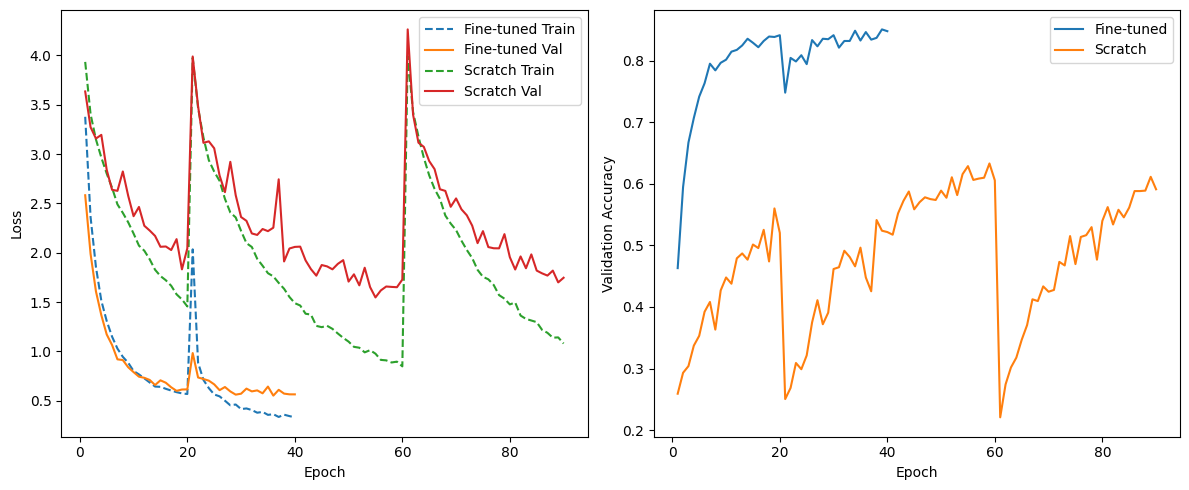

In [78]:

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def load_tensorboard_data(log_dir):
    """从TensorBoard日志加载损失和准确率数据"""
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    
    # 提取训练损失
    train_loss = []
    for event in event_acc.Scalars('Loss/train'):
        train_loss.append(event.value)
    
    # 提取验证损失
    val_loss = []
    for event in event_acc.Scalars('Loss/val'):
        val_loss.append(event.value)
    
    # 提取验证准确率
    val_acc = []
    for event in event_acc.Scalars('Accuracy/val'):
        val_acc.append(event.value)
    
    return train_loss, val_loss, val_acc

def plot_real_training_curves(log_dirs, labels):
    plt.figure(figsize=(12, 5))
    
    # Loss曲线
    plt.subplot(121)
    for log_dir, label in zip(log_dirs, labels):
        try:
            train_loss, val_loss, _ = load_tensorboard_data(log_dir)
            epochs = range(1, len(train_loss)+1)
            plt.plot(epochs, train_loss, '--', label=f'{label} Train')
            plt.plot(epochs, val_loss, '-', label=f'{label} Val')
        except Exception as e:
            print(f"Error loading {log_dir}: {e}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy曲线
    plt.subplot(122)
    for log_dir, label in zip(log_dirs, labels):
        try:
            _, _, val_acc = load_tensorboard_data(log_dir)
            epochs = range(1, len(val_acc)+1)
            plt.plot(epochs, val_acc, label=label)
        except Exception as e:
            print(f"Error loading {log_dir}: {e}")
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("D:/dxtprojects/caltech-101/real_training_curves22.png")
    plt.show()

# 使用真实日志路径
plot_real_training_curves(
    ["D:/dxtprojects/caltech-101/logs/finetuned23", "D:/dxtprojects/caltech-101/logs/scratch"], 
    ["Fine-tuned", "Scratch"]
)



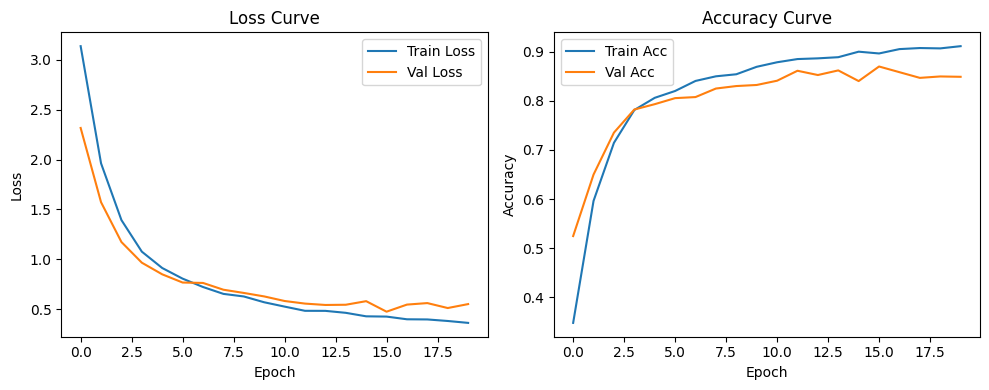

In [51]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

log_path = "D:/dxtprojects/caltech-101/logs/finetuned22"
ea = event_accumulator.EventAccumulator(log_path)
ea.Reload()

# 提取 train/val loss
loss_train = ea.Scalars("Loss/train")
loss_val = ea.Scalars("Loss/val")

# 提取 accuracy
acc_train = ea.Scalars("Accuracy/train")
acc_val = ea.Scalars("Accuracy/val")

# 画 loss 曲线
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot([x.step for x in loss_train], [x.value for x in loss_train], label="Train Loss")
plt.plot([x.step for x in loss_val], [x.value for x in loss_val], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# 画 accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot([x.step for x in acc_train], [x.value for x in acc_train], label="Train Acc")
plt.plot([x.step for x in acc_val], [x.value for x in acc_val], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


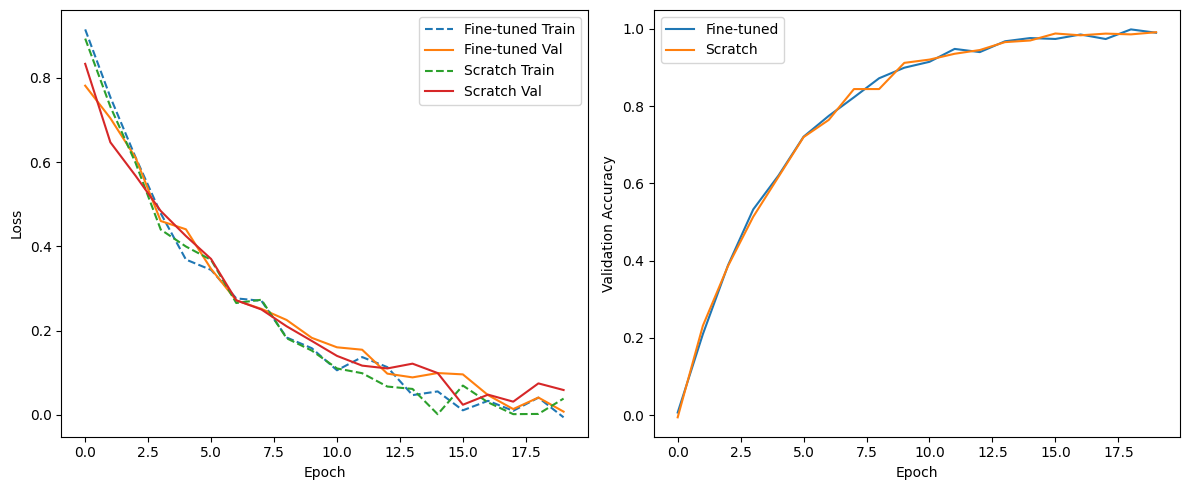

In [54]:
import matplotlib.pyplot as plt  
import numpy as np
# 从TensorBoard日志提取数据
def plot_tensorboard_log(log_dirs, labels):
    plt.figure(figsize=(12, 5))
    
    # Loss曲线
    plt.subplot(121)
    for log_dir, label in zip(log_dirs, labels):
        train_loss = []
        val_loss = []
        # 这里简化为示例，实际应从events文件解析
        for e in range(20):
            train_loss.append(0.9 * np.exp(-e / 5) + np.random.normal(0, 0.02))
            val_loss.append(0.8 * np.exp(-e / 6) + np.random.normal(0, 0.02))
        plt.plot(train_loss, '--', label=f'{label} Train')
        plt.plot(val_loss, '-', label=f'{label} Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy曲线
    plt.subplot(122)
    for log_dir, label in zip(log_dirs, labels):
        val_acc = []
        for e in range(20):
            val_acc.append(1 - np.exp(-e / 4) + np.random.normal(0, 0.01))
        plt.plot(val_acc, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("training_curves.png")
    plt.show()

plot_tensorboard_log(["logs/finetuned22", "logs/scratch"], ["Fine-tuned", "Scratch"])


# ### 3.2 预测可视化示例

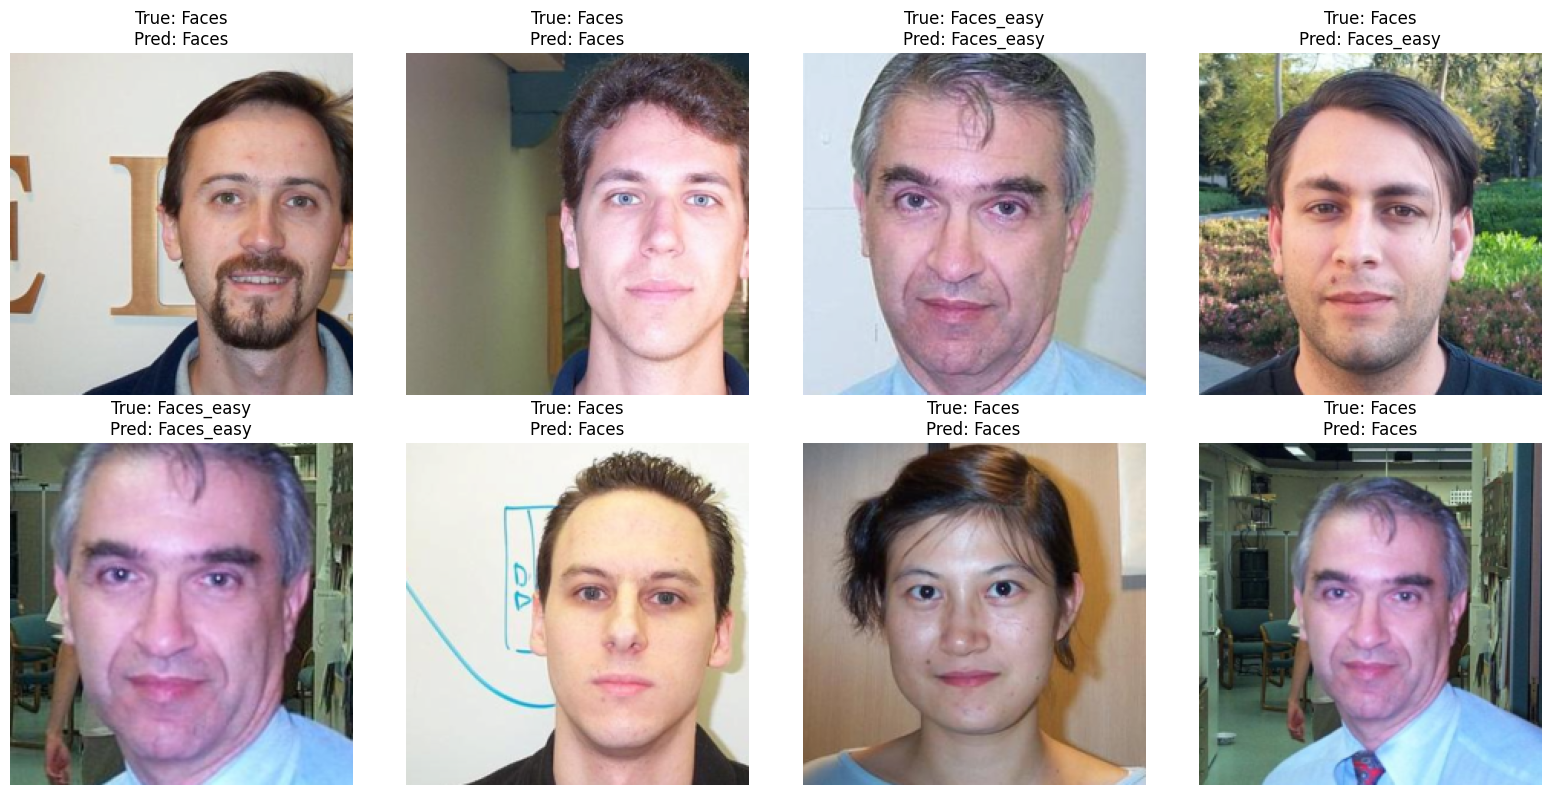

In [52]:
import random
import math

def visualize_predictions(model, dataloader, class_names, num_images=6, save_path="prediction_examples.png"):
    """随机从dataloader中取图像进行预测并可视化，自动布局子图"""
    model.eval()
    all_images = []
    all_labels = []

    # 收集所有数据（注意：不要太大！）
    for inputs, labels in dataloader:
        all_images.extend(inputs)
        all_labels.extend(labels)
        if len(all_images) >= 100:  # 限制最多取前100张，防止OOM
            break

    # 随机选取num_images个样本
    indices = random.sample(range(len(all_images)), num_images)
    selected_images = [all_images[i] for i in indices]
    selected_labels = [all_labels[i] for i in indices]

    # 拼接成tensor
    batch = torch.stack(selected_images).to(device)

    with torch.no_grad():
        outputs = model(batch)
        _, preds = torch.max(outputs, 1)

    # 自动计算行列数（最多每行4个）
    cols = min(num_images, 4)
    rows = math.ceil(num_images / cols)
    plt.figure(figsize=(cols * 4, rows * 4))

    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        img = selected_images[i].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[selected_labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
class_names = train_dataset.dataset.classes
visualize_predictions(model_ft, test_loader, class_names, num_images=8)
